<a href="https://colab.research.google.com/github/MLDEVGIT/Data_Mining-_2025/blob/main/Colab_Base_para_el_Trabajo_Pr%C3%A1ctico_(versi%C3%B3n_4)_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Base para el Trabajo Práctico (versión 4)
Programa de creación de entregas. Versión 4


In [ ]:
#Importación
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics

#Union al Drive
from google.colab import drive
drive.mount("/content/drive")

#Seteo del Front
sns.set(style="whitegrid")  # Estilo visual más limpio
plt.rcParams["figure.figsize"] = (10, 6)  # Tamaño por defecto


Mounted at /content/drive


## 0. Lectura de datos y filtros brutos

In [ ]:
# TODO: Cambiar para que apunte al directorio correcto
DIR = "/content/drive/MyDrive/Maestría/Data_Mining/fcen-dm-2025-prediccion-precio-de-propiedades/entrenamiento"
df_ent = pd.read_csv(f"{DIR}/entrenamiento.csv", index_col="id")


#-----------
#Proceso de filtrado inicial
#------------

# Eliminar columnas con muchos NaN y poca utilidad
df_ent = df_ent.drop(columns=["l4", "l5", "l6","price_period","title" ], errors="ignore")

# Renombrar columnas lat <-> lon

df_ent = df_ent.rename(columns={"lat": "tmp_lon", "lon": "tmp_lat"})
df_ent = df_ent.rename(columns={"tmp_lon": "lon", "tmp_lat": "lat"})

# Filtro para eliminar propiedades sin precio!
df_ent = df_ent[~df_ent["price"].isnull()]

# Filtro para quedarnos solo con propiedades ubicadas en Argentina
df_ent = df_ent[df_ent["l1"] == "Argentina"]

# Filtro para quedarnos solo con propiedades ubicadas en Capital Federal
df_ent = df_ent[df_ent["l2"] == "Capital Federal"]
print("Cantidad de registros en Capital Federal:", df_ent.shape[0])


# Filtrar solo operaciones de venta
df_ent = df_ent[df_ent["operation_type"] == "Venta"]

#Filtrar operaciones que esten en dólares
df_ent = df_ent[df_ent["currency"] == "USD"]

# Contar cuántos registros hay por tipo de propiedad y filtro por items con más de 10.000 registros
conteo_pt = df_ent["property_type"].value_counts()
pt_validos = conteo_pt[conteo_pt >= 10000].index
df_ent = df_ent[df_ent["property_type"].isin(pt_validos)]
print("Tipos de propiedad seleccionados (con >= 10.000 registros):")
print(list(pt_validos))
print("Shape final luego de filtrar por property_type:", df_ent.shape)


#Filtro por precios fuera de los quantiles 0.01 y 0.99
q1 = df_ent["price"].quantile(0.01)
q99 = df_ent["price"].quantile(0.99)
df_ent = df_ent[(df_ent["price"] >= q1) & (df_ent["price"] <= q99)]
print("Registros luego de filtrar outliers en precio:", df_ent.shape[0])

#-----------
#Fin del  filtrado inicial
#------------

#Anális explorartorio post filtros brutos

df_ent.head()
# cantidad de filas y columnas
df_ent.shape
# Dimensiones del dataset
print("Forma del dataset:", df_ent.shape)
# Primeras filas
display(df_ent.head())
# Información general del dataset
print("\nResumen de columnas:")
df_ent.info()
# Estadísticas descriptivas (solo columnas numéricas)
display(df_ent.describe())
# Porcentaje de valores nulos por columna
print("\nPorcentaje de valores nulos por columna:")
print((df_ent.isnull().mean() * 100).sort_values(ascending=False))

# Tipos de datos únicos para columnas categóricas clave
cat_cols = ["property_type", "operation_type", "l1", "l2", "l3","place_name", "currency", "ad_type"]
for col in cat_cols:
    if col in df_ent.columns:
        print(f"\nValores únicos en '{col}':")
        print(df_ent[col].value_counts(dropna=False))

Cantidad de registros en Capital Federal: 235558
Zonas seleccionadas (l2 con >= 20000 registros):
['Capital Federal']
Shape final luego de filtrar por l2: (162048, 19)
Tipos de propiedad seleccionados (con >= 10.000 registros):
['Departamento', 'Otro', 'PH']
Shape final luego de filtrar por property_type: (131405, 19)
Registros luego de filtrar outliers en precio: 128793
Forma del dataset: (128793, 19)


,ad_type,start_date,end_date,created_on,lon,lat,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,currency,description,property_type,operation_type,price
id,,,,,,,,,,,,,,,,,,,
556713,Propiedad,2019-11-29,9999-12-31,2019-11-29,-58.442399,-34.573623,Argentina,Capital Federal,Colegiales,3.0,2.0,2.0,NaN,NaN,USD,"Sup total por escritura: 96,47 m2 (cubiertos: ...",Departamento,Venta,259000.0
257134,Propiedad,2019-08-17,9999-12-31,2019-08-17,-58.420737,-34.631770,Argentina,Capital Federal,Boedo,2.0,1.0,1.0,74.0,47.0,USD,Corredor Responsable: MARCELO TRUJILLO - CPI ...,PH,Venta,140000.0
521738,Propiedad,2019-08-05,2019-08-31,2019-08-05,-58.429983,-34.607225,Argentina,Capital Federal,Almagro,3.0,2.0,1.0,66.0,64.0,USD,Corredor Responsable: Marcelo Trujillo - CUCIC...,Departamento,Venta,173000.0
383947,Propiedad,2019-10-23,2019-11-08,2019-10-23,-58.420780,-34.608640,Argentina,Capital Federal,Almagro,3.0,2.0,1.0,55.0,55.0,USD,"Muy Lindo ph al contrafrente con 2 patios!, 80...",PH,Venta,155000.0
986212,Propiedad,2019-08-01,2019-08-14,2019-08-01,-58.371394,-34.621835,Argentina,Capital Federal,San Telmo,3.0,2.0,1.0,42.0,42.0,USD,PH en Edificio Frances en Estado original!!!al...,PH,Venta,74000.0



Resumen de columnas:
<class 'pandas.core.frame.DataFrame'>
Index: 128793 entries, 556713 to 999954
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ad_type          128793 non-null  object 
 1   start_date       128793 non-null  object 
 2   end_date         128793 non-null  object 
 3   created_on       128793 non-null  object 
 4   lon              109172 non-null  float64
 5   lat              109233 non-null  float64
 6   l1               128793 non-null  object 
 7   l2               128793 non-null  object 
 8   l3               112574 non-null  object 
 9   rooms            97742 non-null   float64
 10  bedrooms         73659 non-null   float64
 11  bathrooms        119570 non-null  float64
 12  surface_total    78693 non-null   float64
 13  surface_covered  80173 non-null   float64
 14  currency         128793 non-null  object 
 15  description      128793 non-null  object 
 16  property_type   

,lon,lat,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,109172.000000,109233.000000,97742.000000,73659.000000,119570.000000,78693.000000,80173.000000,1.287930e+05
mean,-58.485961,-34.576875,2.683002,1.912149,1.464782,104.691891,88.664638,2.092435e+05
std,0.565352,0.344261,1.346043,1.925182,0.797194,989.558941,845.842890,1.924390e+05
min,-71.658058,-46.591166,1.000000,0.000000,1.000000,0.000000,1.000000,2.175500e+04
25%,-58.461856,-34.615615,2.000000,1.000000,1.000000,44.000000,40.000000,9.990000e+04
50%,-58.436128,-34.599820,3.000000,2.000000,1.000000,65.000000,57.000000,1.500000e+05
75%,-58.411195,-34.582235,3.000000,3.000000,2.000000,100.000000,86.000000,2.425000e+05
max,-53.828578,1.000000,36.000000,303.000000,20.000000,126062.000000,126062.000000,1.500000e+06



Porcentaje de valores nulos por columna:
bedrooms           42.808227
surface_total      38.899630
surface_covered    37.750499
rooms              24.109230
lon                15.234524
lat                15.187161
l3                 12.593076
bathrooms           7.161103
end_date            0.000000
ad_type             0.000000
start_date          0.000000
l2                  0.000000
l1                  0.000000
created_on          0.000000
currency            0.000000
description         0.000000
property_type       0.000000
operation_type      0.000000
price               0.000000
dtype: float64

Valores únicos en 'property_type':
property_type
Departamento    92595
Otro            24787
PH              11411
Name: count, dtype: int64

Valores únicos en 'operation_type':
operation_type
Venta    128793
Name: count, dtype: int64

Valores únicos en 'l1':
l1
Argentina    128793
Name: count, dtype: int64

Valores únicos en 'l2':
l2
Capital Federal    128793
Name: count, dtype: int64

V

## 1. Entender los datos (AID)

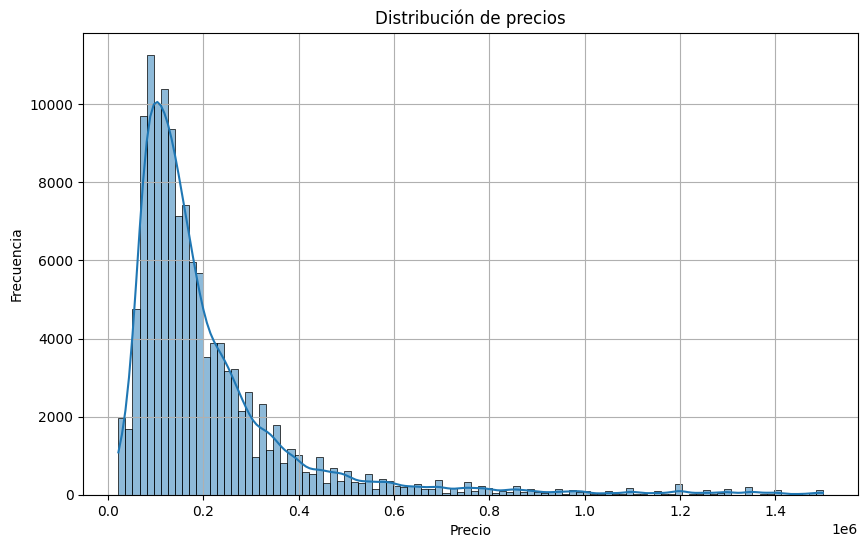

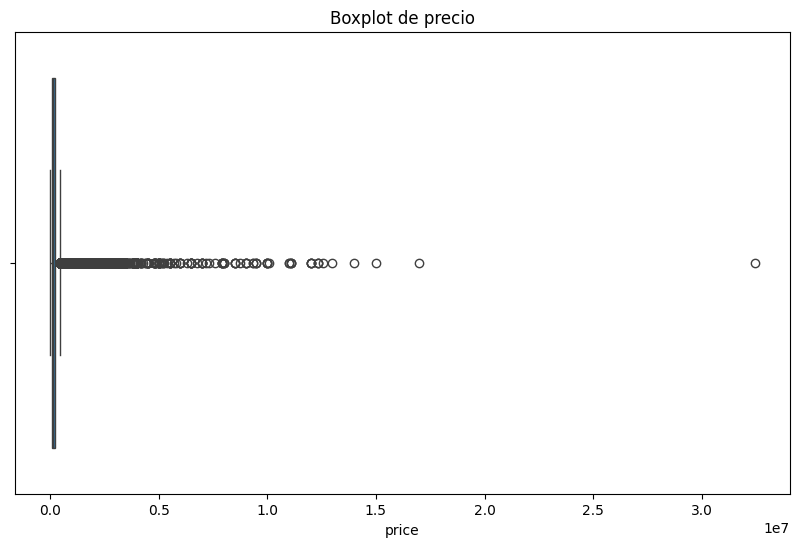

Precio máximo: 32434232.0
Precio percentil 99: 1500000.0


In [ ]:
# Tamaño por defecto de los plots
plt.rcParams["figure.figsize"] = (10, 6)
#df_ent["property_type"].hist(figsize=(15,5));

#Distribución de precios
sns.histplot(df_ent["price"], bins=100, kde=True)
plt.title("Distribución de precios")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

sns.boxplot(x=df_clean["price"])
plt.title("Boxplot de precio")
plt.show()

print("Precio máximo:", df_clean["price"].max())
print("Precio percentil 99:", df_clean["price"].quantile(0.99))



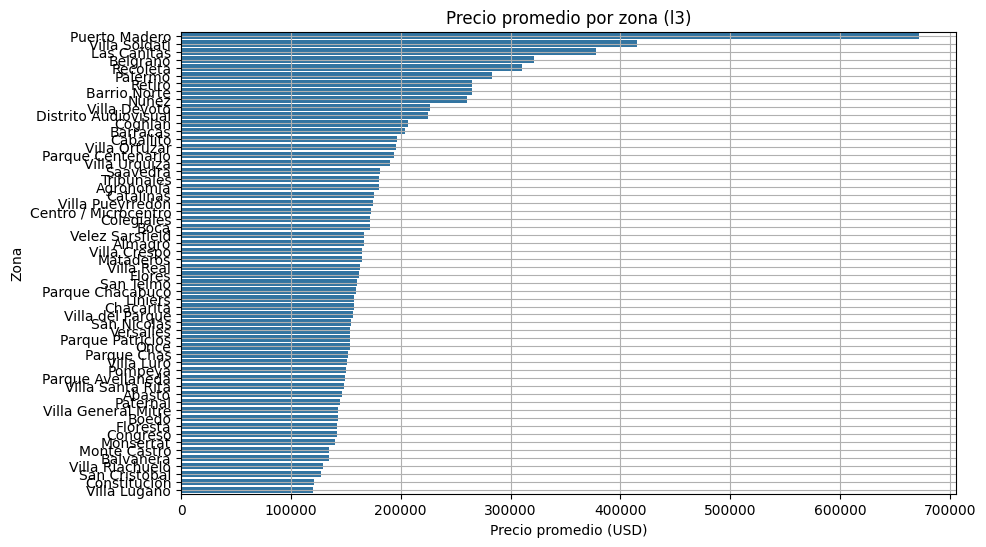

In [ ]:
#Precio promedio por zona (l2 en este caso)

avg_price_by_l2 = df_ent.groupby("l3")["price"].mean().sort_values(ascending=False)

sns.barplot(x=avg_price_by_l2.values, y=avg_price_by_l2.index)
plt.title("Precio promedio por zona (l3)")
plt.xlabel("Precio promedio (USD)")
plt.ylabel("Zona")
plt.grid(True)
plt.show()


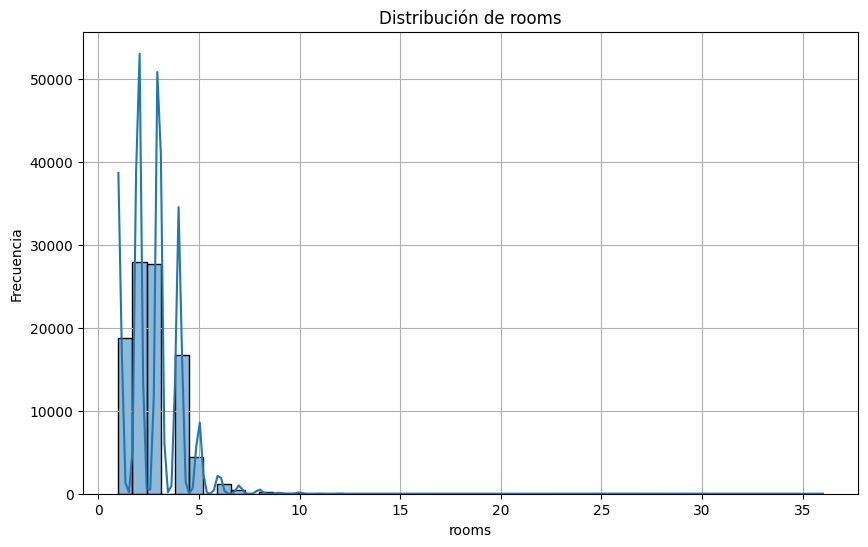

In [ ]:
#Otras variables numéricas
num_cols = ["surface_total_in_m2", "surface_covered_in_m2", "rooms"]

for col in num_cols:
    if col in df_ent.columns:
        sns.histplot(df_ent[col], bins=50, kde=True)
        plt.title(f"Distribución de {col}")
        plt.xlabel(col)
        plt.ylabel("Frecuencia")
        plt.grid(True)
        plt.show()


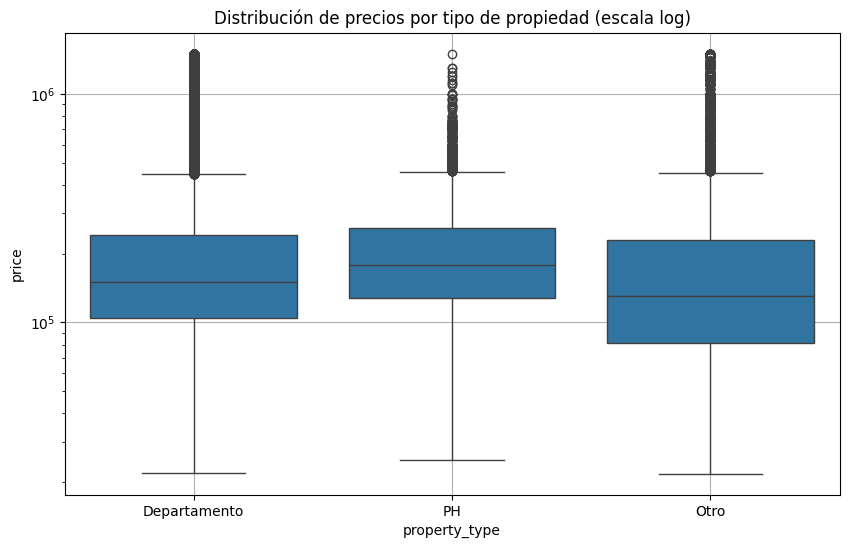

In [ ]:
#Precio por tipo de propiedad
if "property_type" in df_ent.columns:
    sns.boxplot(data=df_ent, x="property_type", y="price")
    plt.yscale("log")  # log para ver mejor la dispersión
    plt.title("Distribución de precios por tipo de propiedad (escala log)")
    plt.grid(True)
    plt.show()

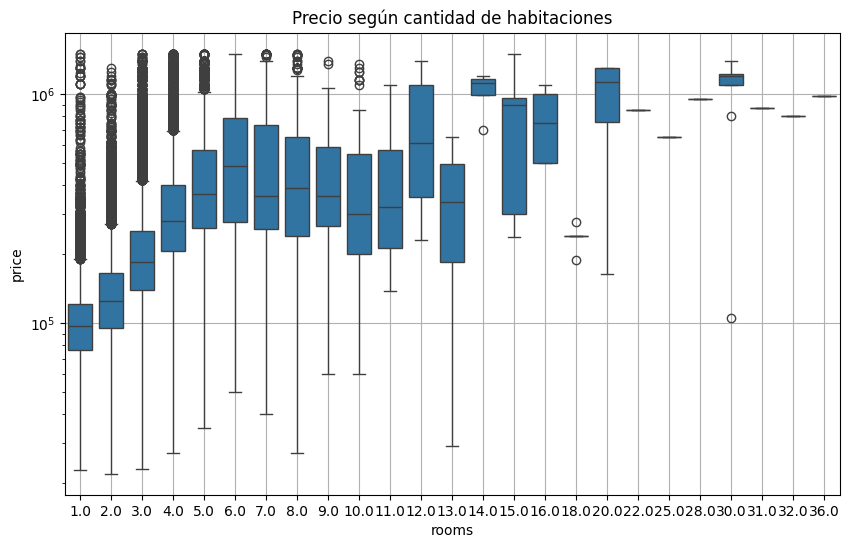

In [ ]:
#Precio por cantidad de habitaciones
sns.boxplot(data=df_ent, x="rooms", y="price")
plt.title("Precio según cantidad de habitaciones")
plt.yscale("log")
plt.grid(True)
plt.show()


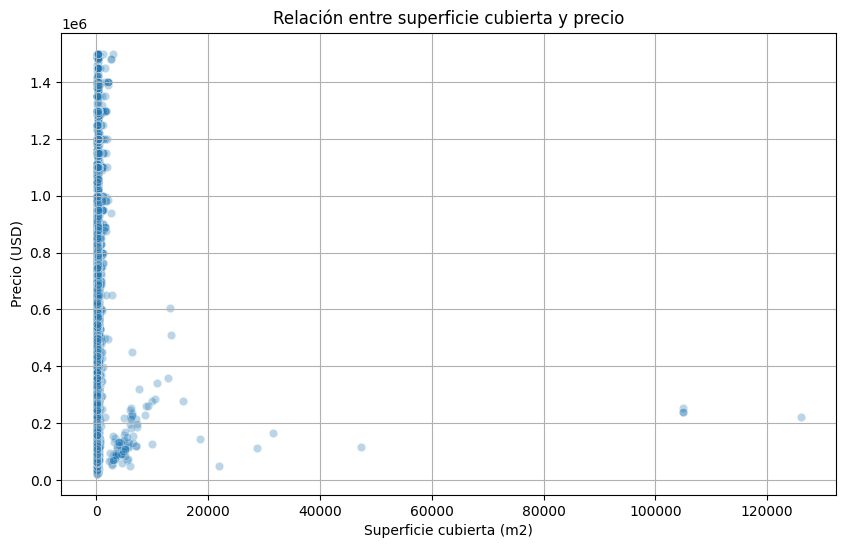

In [ ]:
#Superficie cubierta vs precio
sns.scatterplot(data=df_ent, x="surface_covered", y="price", alpha=0.3)
plt.title("Relación entre superficie cubierta y precio")
plt.xlabel("Superficie cubierta (m2)")
plt.ylabel("Precio (USD)")
plt.grid(True)
plt.show()


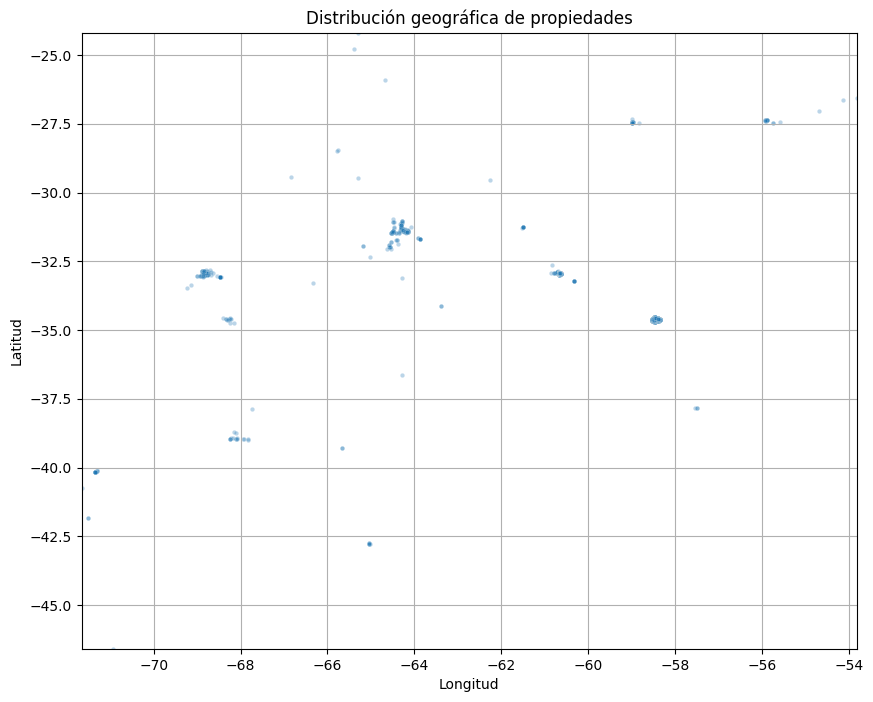

In [ ]:
# Filtrar registros con coordenadas válidas
geo_df = df_ent.dropna(subset=["lat", "lon"])

# Obtener los límites
min_lat, max_lat = geo_df["lat"].min(), geo_df["lat"].max()
min_lon, max_lon = geo_df["lon"].min(), geo_df["lon"].max()

# Gráfico con ejes invertidos (lon en eje X, lat en eje Y)
plt.figure(figsize=(10, 8))
sns.scatterplot(data=geo_df, x="lon", y="lat", alpha=0.3, s=10)
plt.title("Distribución geográfica de propiedades")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.xlim(min_lon, max_lon)
plt.ylim(min_lat, max_lat)
plt.grid(True)
plt.show()




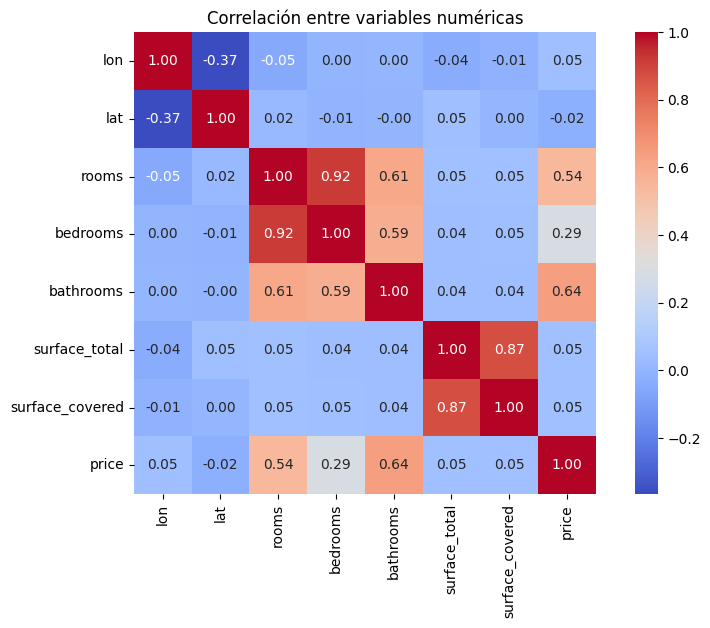

In [ ]:
#Hya correlaciones? Hay cosas raras
corr = df_ent.select_dtypes(include='number').corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlación entre variables numéricas")
plt.show()


## 2. Limpiar y transformar los datos (MD)

In [ ]:
#Limpieza de outliers
#Filtramos propiedades con precios y superficies fuera de rango razonable:

# Filtros básicos para eliminar registros extremos
df_clean = df_ent.copy()

# Precio fuera de rango (10000 o más de 1.5 millones)
df_clean = df_clean[(df_clean["price"] > 10000) & (df_clean["price"] < 1500000)]

# Superficie total (entre 25 m2 y 1000 m2)
df_clean = df_clean[(df_clean["surface_total"] >= 25) & (df_clean["surface_total"] <= 1000)]

# Superficie cubierta entre 15 y 500 m2
df_clean = df_clean[(df_clean["surface_covered"] >= 15) & (df_clean["surface_covered"] <= 500)]

#print(df_clean["rooms"].value_counts().sort_index()) #cuantos registros hay por cantidad de rooms

# Cantidad de habitaciones razonable (1 a 8)
df_clean = df_clean[(df_clean["rooms"] >= 1) & (df_clean["rooms"] <= 8)]

# Cantidad de baños razonable (1 a 4)
df_clean = df_clean[(df_clean["bathrooms"] >= 1) & (df_clean["rooms"] <= 4)]

# Porcentaje de valores nulos por columna
print("\nPorcentaje de valores nulos por columna:")
print((df_clean.isnull().mean() * 100).sort_values(ascending=False))


Porcentaje de valores nulos por columna:
bedrooms           27.756769
lon                 5.041207
lat                 5.041207
l3                  0.155184
end_date            0.000000
ad_type             0.000000
start_date          0.000000
l1                  0.000000
created_on          0.000000
l2                  0.000000
rooms               0.000000
bathrooms           0.000000
surface_total       0.000000
surface_covered     0.000000
currency            0.000000
description         0.000000
property_type       0.000000
operation_type      0.000000
price               0.000000
dtype: float64


In [ ]:
#Imputación condicional

#-----------------------
#Aca hay que laburar mucho todavía, la tiro
#------------------------

# -----------------------------------
# Tratamiento especial: bedrooms = rooms - bathrooms (si ambos existen)
# -----------------------------------

df_clean["bathrooms"] = df_clean["bathrooms"].fillna(1) #Imputo primero los baños

cond = (
    df_clean["bedrooms"].isna() &
    df_clean["rooms"].notna() &
    df_clean["bathrooms"].notna()
)
df_clean.loc[cond, "bedrooms"] = df_clean.loc[cond, "rooms"] - df_clean.loc[cond, "bathrooms"]

# -----------------------------------
# Tratamiento especial: bedrooms = rooms - bathrooms (final)
# -----------------------------------

# ----------------------------------------
# Reemplazar lat y lon NaN por la moda de l3
# ----------------------------------------

# Función auxiliar para aplicar por fila
def imputar_moda_por_l3(row, columna, mapa_moda):
    if pd.isna(row[columna]):
        return mapa_moda.get(row["l3"], np.nan)
    else:
        return row[columna]

# Calcular modas por l3
lat_moda_por_l3 = df_clean.groupby("l3")["lat"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).to_dict()
lon_moda_por_l3 = df_clean.groupby("l3")["lon"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).to_dict()

# Aplicar imputación solo si NaN
df_clean["lat"] = df_clean.apply(lambda row: imputar_moda_por_l3(row, "lat", lat_moda_por_l3), axis=1)
df_clean["lon"] = df_clean.apply(lambda row: imputar_moda_por_l3(row, "lon", lon_moda_por_l3), axis=1)

print("Lat faltantes después:", df_clean["lat"].isna().sum())
print("Lon faltantes después:", df_clean["lon"].isna().sum())

# Filtrar los registros con lat o lon nulos
df_missing_coords = df_clean[df_clean["lat"].isna() | df_clean["lon"].isna()]

# Aumentar el número de filas que muestra pandas
pd.set_option("display.max_rows", None)

# Mostrar todos los registros
#display(df_missing_coords)

#df_missing_coords.to_csv("registros_con_lat_lon_faltantes.csv")

# Eliminar registros sin coordenadas geográficas
df_clean = df_clean.dropna(subset=["lat", "lon"])


# ----------------------------------------
# Reemplazar lat y lon NaN por la moda de l3 (final)
# ----------------------------------------

# Si surface_covered está vacío pero surface_total existe, lo copiamos
cond_covered = df_clean["surface_covered"].isna() & df_clean["surface_total"].notna()
df_clean.loc[cond_covered, "surface_covered"] = df_clean.loc[cond_covered, "surface_total"]

# Si surface_total está vacío pero surface_covered existe, lo copiamos
cond_total = df_clean["surface_total"].isna() & df_clean["surface_covered"].notna()
df_clean.loc[cond_total, "surface_total"] = df_clean.loc[cond_total, "surface_covered"]

print("Registros con surface_covered aún NaN:", df_clean["surface_covered"].isna().sum())
print("Registros con surface_total aún NaN:", df_clean["surface_total"].isna().sum())


# #Imputamos con mediana solo si hay valores nulos:

from sklearn.impute import SimpleImputer

# Lista de columnas a imputar (solo numéricas)
num_cols = ["rooms"]

# Imputador con la mediana
imputer = SimpleImputer(strategy="median")
df_clean[num_cols] = imputer.fit_transform(df_clean[num_cols])


Lat faltantes después: 46
Lon faltantes después: 46
Registros con surface_covered aún NaN: 0
Registros con surface_total aún NaN: 0


<ipython-input-314-423abf639340>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[num_cols] = imputer.fit_transform(df_clean[num_cols])


In [ ]:
#Creación de nuevos features
#Creamos la relación entre superficies, que puede ayudar:

# Evitar división por cero
df_clean["ratio_covered_total"] = df_clean["surface_covered"] / df_clean["surface_total"]
df_clean["ratio_covered_total"] = df_clean["ratio_covered_total"].replace([np.inf, -np.inf], np.nan).fillna(0)


<ipython-input-315-a2155a1abd5b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["ratio_covered_total"] = df_clean["surface_covered"] / df_clean["surface_total"]
<ipython-input-315-a2155a1abd5b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["ratio_covered_total"] = df_clean["ratio_covered_total"].replace([np.inf, -np.inf], np.nan).fillna(0)


In [ ]:
#Codificación de variables categóricas
#Vamos con One-Hot para las más relevantes:

# Variables categóricas importantes
cat_cols = ["property_type", "operation_type", "l2"]

# Codificación One-Hot
df_clean = pd.get_dummies(df_clean, columns=cat_cols, drop_first=True)


In [ ]:
# Ver cuántos registros quedaron luego del preprocesamiento
print("Cantidad de registros luego del preprocesamiento:", df_clean.shape[0])
print("Cantidad de columnas luego del preprocesamiento:", df_clean.shape[1])

# registros fueron eliminados respecto al original filtrado
registros_eliminados = df_ent.shape[0] - df_clean.shape[0]
print(f"Se eliminaron {registros_eliminados} registros durante el preprocesamiento.")

# Porcentaje de valores nulos por columna
print("\nPorcentaje de valores nulos por columna:")
print((df_clean.isnull().mean() * 100).sort_values(ascending=False))


Cantidad de registros luego del preprocesamiento: 66327
Cantidad de columnas luego del preprocesamiento: 19
Se eliminaron 62466 registros durante el preprocesamiento.

Porcentaje de valores nulos por columna:
l3                     0.085938
start_date             0.000000
ad_type                0.000000
end_date               0.000000
created_on             0.000000
lat                    0.000000
lon                    0.000000
l1                     0.000000
rooms                  0.000000
bedrooms               0.000000
bathrooms              0.000000
surface_total          0.000000
surface_covered        0.000000
currency               0.000000
description            0.000000
price                  0.000000
ratio_covered_total    0.000000
property_type_Otro     0.000000
property_type_PH       0.000000
dtype: float64


## 3. Entrenamiento del modelos (AA)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# -----------------------------------
# Features (X) y Target (y)
# -----------------------------------

# Usamos todas las columnas numéricas excepto 'price'
X = df_clean.drop(columns=["price"])
X = X.select_dtypes(include=["number"])

y = df_clean["price"]

# -----------------------------------
# División en entrenamiento / test
# -----------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------------
# Configuración y entrenamiento del modelo
# -----------------------------------
reg = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    n_jobs=-1,
    random_state=42
)
reg.fit(X_train, y_train)

# -----------------------------------
# Evaluación del modelo
# -----------------------------------
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"RMSE - Entrenamiento: {rmse_train:,.2f}")
print(f"RMSE - Test:          {rmse_test:,.2f}")


RMSE - Entrenamiento: 50,418.54
RMSE - Test:          55,050.60


## 4. Solución para subir Kaggle

In [ ]:
# -----------------------------
# Cargar datos a predecir
# -----------------------------
df_ap = pd.read_csv(f"{DIR}/a_predecir.csv", index_col="id")


df_ap = df_ap.drop(columns=["l4", "l5", "l6","price_period","title"], errors="ignore")

df_ap = df_ap.rename(columns={"lat": "tmp_lon", "lon": "tmp_lat"})
df_ap = df_ap.rename(columns={"tmp_lon": "lon", "tmp_lat": "lat"})

# -----------------------------
# Imputación de columnas numéricas
# -----------------------------
df_ap[num_cols] = imputer.transform(df_ap[num_cols])

# -----------------------------
# Variables derivadas
# -----------------------------
df_ap["relacion_cubierta_total"] = df_ap["surface_covered"] / df_ap["surface_total"]
df_ap["relacion_cubierta_total"] = df_ap["relacion_cubierta_total"].replace([np.inf, -np.inf], np.nan).fillna(0)

df_ap["superficie_sin_cubrir"] = df_ap["surface_total"] - df_ap["surface_covered"]
df_ap["superficie_sin_cubrir"] = df_ap["superficie_sin_cubrir"].fillna(0)

# -----------------------------
# Codificación categórica (igual que en entrenamiento)
# -----------------------------
df_ap = pd.get_dummies(df_ap, columns=cat_cols, drop_first=True)

# -----------------------------
# Alinear columnas con entrenamiento
# -----------------------------
missing_cols = set(X.columns) - set(df_ap.columns)
for col in missing_cols:
    df_ap[col] = 0

df_ap = df_ap[X.columns]

# -----------------------------
# Predecir precios
# -----------------------------
y_pred_ap = reg.predict(df_ap)

# -----------------------------
# Generar archivo para Kaggle
# -----------------------------
df_solucion = pd.DataFrame({"id": df_ap.index, "price": y_pred_ap})
df_solucion.set_index("id", inplace=True)
df_solucion.to_csv("solucion.csv")

print(" Archivo solucion.csv generado exitosamente.")


 Archivo solucion.csv generado exitosamente.
